In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import zipfile
import os

dataset_path = '/content/drive/MyDrive/archive.zip'

extract_path = '/content/data'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [6]:
data_path = '/content/data/powerconsumption.csv'
df = pd.read_csv(data_path)
df.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


### Этап 2. Предварительная очистка и предобработка данных
Задача: Привести данные в единый, анализируемый вид.

✅ Что нужно сделать:

- Привести все временные метки к единому формату и временной зоне (например, Europe/Moscow)

- Удалить дубликаты по времени

- Проверить монотонность временного ряда (нет “прыжков” или “возвратов” во времени)

- Обработать пропуски:

- Интерполяция (линейная, полиномиальная)

  - Заполнение скользящим средним

  - Удаление (если <5%)

Обнаружить и обработать выбросы:

  - Метод IQR (межквартильный размах)

  - Z-score (если распределение близко к нормальному)

  - Визуально (boxplot, scatter plot)

При необходимости — ресемплировать ряд до единой частоты (например, “D” — ежедневно)

🛠️ Инструменты: pandas, numpy, pytz

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Стандартизация времени

In [8]:
def standardize_timestamps(df, time_column='timestamp', target_timezone='Europe/Moscow'):
    """
    Приведение временных меток к единому формату и временной зоне
    """
    df_clean = df.copy()

    formats = [
        "%Y-%m-%d %H:%M:%S",
        "%d/%m/%Y %H:%M",
        "%Y-%m-%dT%H:%M:%S%z",
        "%b %d, %Y %I:%M %p",
        "%Y-%m-%d",
        "%d.%m.%Y %H:%M"
    ]

    parsed_times = []
    for time_str in df_clean[time_column]:
        parsed = None
        for fmt in formats:
            try:
                parsed = datetime.strptime(str(time_str), fmt)
                break
            except ValueError:
                continue
        if parsed is None:

            parsed = pd.to_datetime(time_str, errors='coerce')
        parsed_times.append(parsed)

    df_clean['timestamp'] = parsed_times

    if df_clean['timestamp'].dt.tz is None:
        df_clean['timestamp'] = df_clean['timestamp'].dt.tz_localize('UTC')

    moscow_tz = pytz.timezone(target_timezone)
    df_clean['timestamp'] = df_clean['timestamp'].dt.tz_convert(moscow_tz)

    return df_clean

df_clean = standardize_timestamps(df, 'Datetime')
df_clean.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,timestamp
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,2017-01-01 03:00:00+03:00
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,2017-01-01 03:10:00+03:00
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,2017-01-01 03:20:00+03:00
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,2017-01-01 03:30:00+03:00
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,2017-01-01 03:40:00+03:00


Удаление дубликатов по времени

In [10]:
def remove_time_duplicates(df, time_column='datetime'):
    """
    Удаление дубликатов по времени
    """
    print(f"До удаления дубликатов: {len(df)} строк")

    df_sorted = df.sort_values(time_column)

    df_dedup = df_sorted.drop_duplicates(subset=[time_column], keep='first')

    print(f"После удаления дубликатов: {len(df_dedup)} строк")

    return df_dedup

df_clean = remove_time_duplicates(df_clean, 'timestamp')
df_clean.head()

До удаления дубликатов: 52416 строк
После удаления дубликатов: 52416 строк


,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,timestamp
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,2017-01-01 03:00:00+03:00
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,2017-01-01 03:10:00+03:00
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,2017-01-01 03:20:00+03:00
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,2017-01-01 03:30:00+03:00
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,2017-01-01 03:40:00+03:00


Проверить монотонность по времени

In [11]:
def check_time_monotonicity(df, time_column='timestamp'):
    """
    Проверка монотонности временного ряда
    """
    time_diff = df[time_column].diff().dt.total_seconds()

    negative_jumps = time_diff[time_diff < 0]

    if len(negative_jumps) > 0:
        print(f"Обнаружено возвратов во времени: {len(negative_jumps)}")
        print("Индексы с возвратами:", negative_jumps.index.tolist())
    else:
        print("Временной ряд монотонен - возвратов во времени нет")

    large_jumps = time_diff[time_diff > 3600]
    if len(large_jumps) > 0:
        print(f"Обнаружено больших прыжков во времени: {len(large_jumps)}")

    return len(negative_jumps) == 0

is_monotonic = check_time_monotonicity(df_clean)

Временной ряд монотонен - возвратов во времени нет


Обработать пропуски:
  - Интерполяция (линейная, полиномиальная)
  - Заполнение скользящим средним
  - Удаление (если <5%)

In [15]:
def handle_missing_values(df, value_column='value', time_column='timestamp'):
    """
    Обработка пропущенных значений
    """
    df_clean = df.copy()

    missing_count = df_clean[value_column].isna().sum()
    missing_percent = (missing_count / len(df_clean)) * 100

    print(f"Пропусков: {missing_count} ({missing_percent:.2f}%)")

    df_clean = df_clean.sort_values(time_column)

    if missing_percent < 5:
        print("Пропусков <5% - удаляем строки с пропусками")
        df_clean = df_clean.dropna(subset=[value_column])
    else:
        print("Пропусков >=5% - применяем интерполяцию")

        df_clean[value_column] = df_clean[value_column].interpolate(
            method='linear',
            limit_direction='both'
        )

        if df_clean[value_column].isna().any():
            window = min(5, len(df_clean) // 10)
            df_clean[value_column] = df_clean[value_column].fillna(
                df_clean[value_column].rolling(window=window, min_periods=1).mean()
            )

    print(f"После обработки пропусков: {len(df_clean)} строк")
    return df_clean

for column in df_clean.columns:
  df_clean = handle_missing_values(df_clean, column)

Пропусков: 0 (0.00%)
Пропусков <5% - удаляем строки с пропусками
После обработки пропусков: 52416 строк
Пропусков: 0 (0.00%)
Пропусков <5% - удаляем строки с пропусками
После обработки пропусков: 52416 строк
Пропусков: 0 (0.00%)
Пропусков <5% - удаляем строки с пропусками
После обработки пропусков: 52416 строк
Пропусков: 0 (0.00%)
Пропусков <5% - удаляем строки с пропусками
После обработки пропусков: 52416 строк
Пропусков: 0 (0.00%)
Пропусков <5% - удаляем строки с пропусками
После обработки пропусков: 52416 строк
Пропусков: 0 (0.00%)
Пропусков <5% - удаляем строки с пропусками
После обработки пропусков: 52416 строк
Пропусков: 0 (0.00%)
Пропусков <5% - удаляем строки с пропусками
После обработки пропусков: 52416 строк
Пропусков: 0 (0.00%)
Пропусков <5% - удаляем строки с пропусками
После обработки пропусков: 52416 строк
Пропусков: 0 (0.00%)
Пропусков <5% - удаляем строки с пропусками
После обработки пропусков: 52416 строк
Пропусков: 0 (0.00%)
Пропусков <5% - удаляем строки с пропусками

Обнаружить и обработать выбросы:
  - Метод IQR (межквартильный размах)
  - Z-score (если распределение близко к нормальному)
  - Визуально (boxplot, scatter plot)

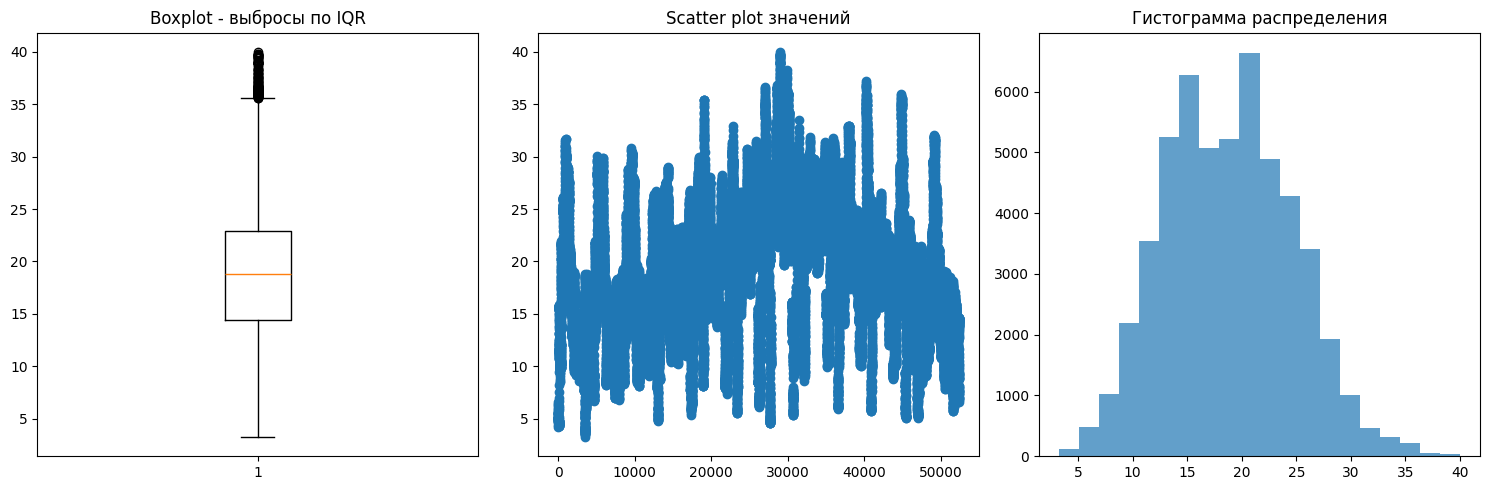

Обнаружено выбросов: 142
Индексы выбросов: [27000, 27001, 27002, 27003, 27004, 27040, 27041, 27042, 27043, 28590, 28591, 28592, 28593, 28594, 28595, 28596, 28597, 28598, 28599, 28600, 28601, 28602, 28603, 28604, 28605, 28606, 28607, 28608, 28609, 28610, 28611, 28612, 28613, 28614, 28615, 28616, 28617, 28618, 29010, 29011, 29012, 29013, 29014, 29015, 29016, 29017, 29018, 29019, 29020, 29021, 29022, 29023, 29024, 29025, 29026, 29027, 29028, 29029, 29030, 29031, 29032, 29033, 29034, 29035, 29036, 29037, 29038, 29039, 29040, 29041, 29042, 29043, 29044, 29045, 29046, 29047, 29048, 29049, 29050, 29051, 29052, 29053, 29054, 29055, 29056, 29057, 29058, 29059, 29060, 29061, 29062, 29736, 29737, 29777, 29778, 29779, 29780, 29781, 29876, 29877, 29878, 29879, 29880, 29881, 29882, 29883, 29884, 29885, 30033, 30034, 30035, 30036, 30037, 30038, 30039, 30040, 30041, 30042, 30043, 30044, 30045, 30046, 30047, 27445, 27446, 27447, 27448, 27449, 27450, 27451, 27452, 27453, 27454, 27455, 27456, 27457, 3190

In [16]:
def detect_and_handle_outliers(df, value_column='value'):
    """
    Обнаружение и обработка выбросов
    """
    df_clean = df.copy()
    values = df_clean[value_column]

    # Метод 1: IQR (межквартильный размах)
    Q1 = values.quantile(0.25)
    Q3 = values.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    iqr_outliers = (values < lower_bound) | (values > upper_bound)

    # Метод 2: Z-score (для нормальных распределений)
    z_scores = np.abs(stats.zscore(values.dropna()))
    z_outliers = z_scores > 3

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.boxplot(values.dropna())
    plt.title('Boxplot - выбросы по IQR')

    plt.subplot(1, 3, 2)
    plt.scatter(range(len(values)), values)
    plt.title('Scatter plot значений')

    plt.subplot(1, 3, 3)
    plt.hist(values.dropna(), bins=20, alpha=0.7)
    plt.title('Гистограмма распределения')

    plt.tight_layout()
    plt.show()

    # Объединяем результаты методов
    if len(values) == len(z_scores):
        all_outliers = iqr_outliers | (z_scores > 3)
    else:
        all_outliers = iqr_outliers

    outlier_count = all_outliers.sum()
    print(f"Обнаружено выбросов: {outlier_count}")

    if outlier_count > 0:
        print("Индексы выбросов:", df_clean[all_outliers].index.tolist())

        # Обработка выбросов - заменяем на граничные значения
        df_clean.loc[all_outliers, value_column] = np.clip(
            values[all_outliers],
            lower_bound,
            upper_bound
        )
        print("Выбросы заменены на граничные значения IQR")

    return df_clean

df_clean = detect_and_handle_outliers(df_clean, 'Temperature')

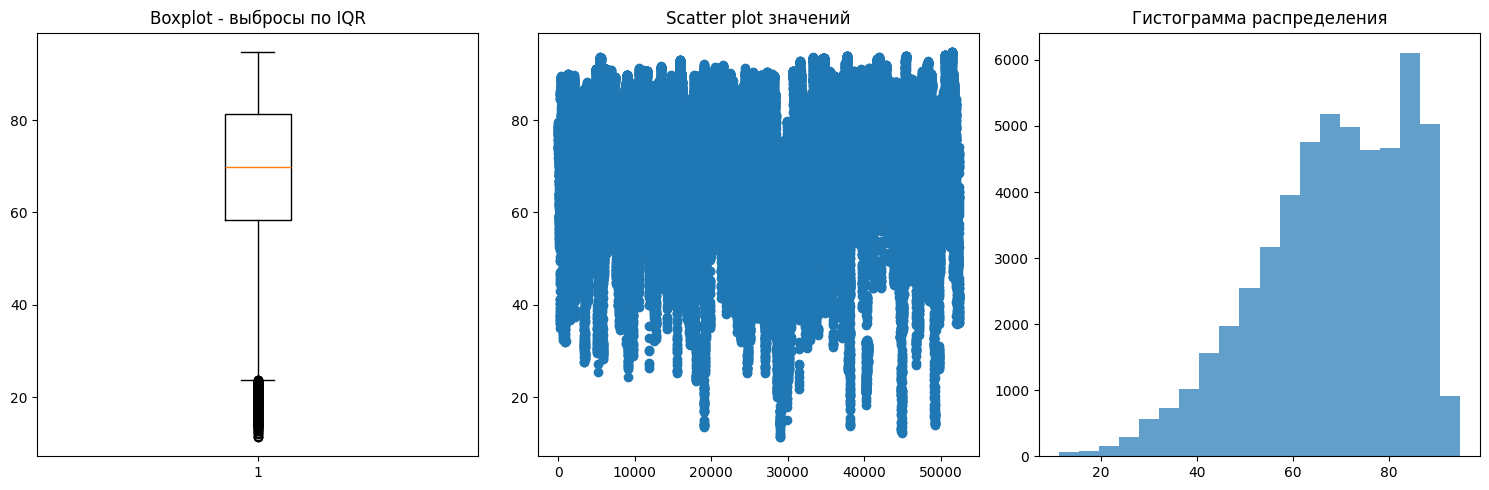

Обнаружено выбросов: 291
Индексы выбросов: [17968, 17969, 19088, 19089, 19090, 19091, 19092, 19093, 19094, 19095, 19096, 19097, 19098, 19099, 19100, 19101, 19102, 19103, 19104, 19105, 19106, 19107, 19108, 19109, 19110, 19111, 19112, 19113, 19114, 19115, 19116, 19117, 19118, 19119, 19120, 19121, 19122, 19123, 28589, 28590, 28591, 28592, 28593, 28595, 28596, 28597, 28598, 28599, 28600, 28604, 28605, 28606, 28607, 28608, 28609, 28610, 28611, 28612, 28613, 28614, 28615, 28616, 29012, 29013, 29014, 29015, 29016, 29017, 29018, 29019, 29020, 29021, 29022, 29023, 29024, 29025, 29026, 29027, 29028, 29029, 29030, 29031, 29032, 29033, 29034, 29035, 29036, 29037, 29038, 29039, 29040, 29041, 29042, 29043, 29044, 29045, 29046, 29047, 29048, 29049, 29050, 29051, 29052, 29053, 29054, 29055, 29056, 29057, 29058, 29059, 29060, 29061, 29062, 29063, 29064, 29065, 29066, 29067, 29068, 29069, 29070, 29071, 29072, 29073, 29778, 29779, 29780, 29781, 29875, 29876, 29877, 29878, 29879, 29880, 29881, 29882, 2988

In [17]:
df_clean = detect_and_handle_outliers(df_clean, 'Humidity')

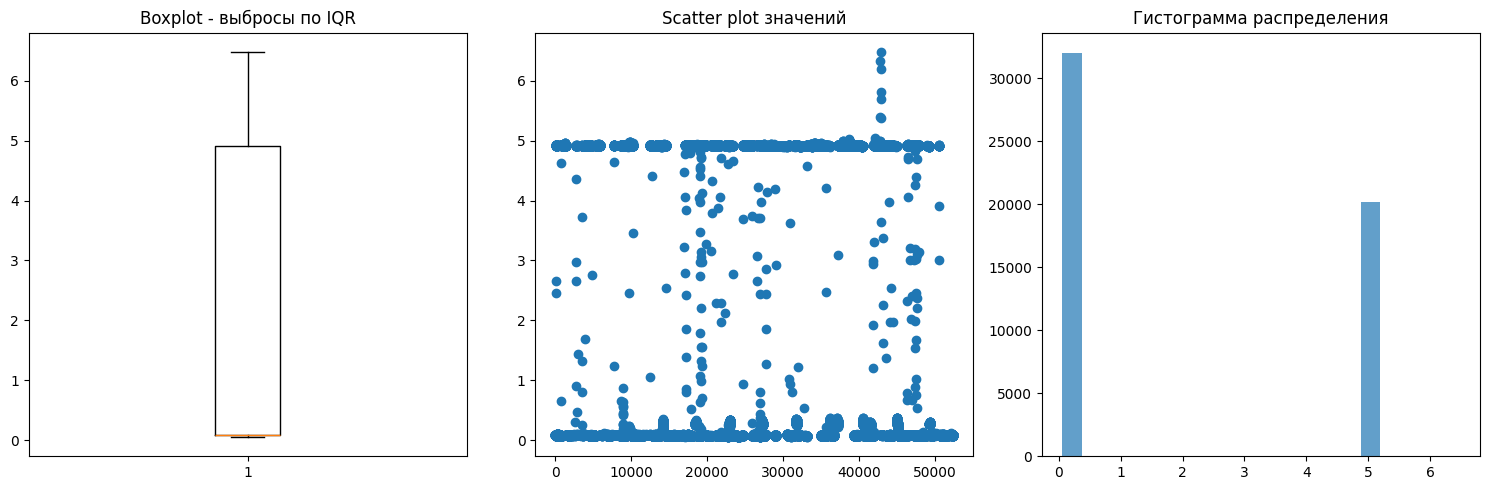

Обнаружено выбросов: 0


In [18]:
df_clean = detect_and_handle_outliers(df_clean, 'WindSpeed')

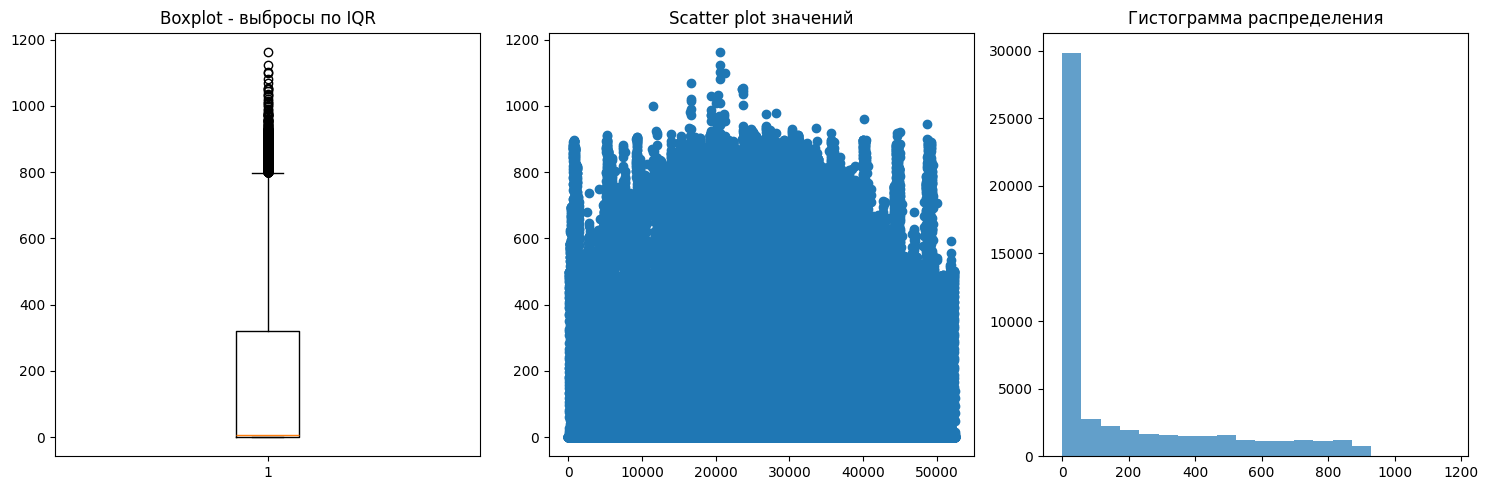

Обнаружено выбросов: 2315
Индексы выбросов: [17350, 17351, 17352, 17353, 17354, 17355, 17356, 17357, 17358, 17359, 17360, 17361, 17362, 17363, 17364, 17365, 17366, 17367, 17368, 17369, 21811, 21812, 21813, 21814, 21815, 21816, 21817, 21818, 21819, 21820, 21821, 21822, 21823, 21824, 21825, 21826, 21827, 21828, 21829, 21830, 21831, 21832, 21833, 21834, 26133, 26134, 26135, 26136, 26137, 26138, 26139, 26140, 26141, 26142, 26143, 26144, 26145, 26146, 26147, 26148, 26149, 26150, 26151, 26152, 26153, 30602, 30603, 30604, 30605, 30606, 30607, 30608, 30609, 30610, 30611, 30613, 35069, 35070, 35071, 35072, 35073, 35074, 17491, 17498, 17499, 17500, 17501, 17502, 21955, 21956, 21957, 21958, 21959, 21960, 21961, 21962, 21963, 21964, 21965, 21966, 21967, 21968, 21969, 21970, 21971, 21972, 21973, 21974, 21975, 21976, 21977, 21978, 21979, 26278, 26279, 26280, 26281, 26282, 26283, 26284, 26285, 26286, 26287, 26288, 26289, 26290, 26291, 26292, 26293, 26294, 26295, 26296, 35210, 35211, 35212, 35213, 352

In [19]:
df_clean = detect_and_handle_outliers(df_clean, 'GeneralDiffuseFlows')

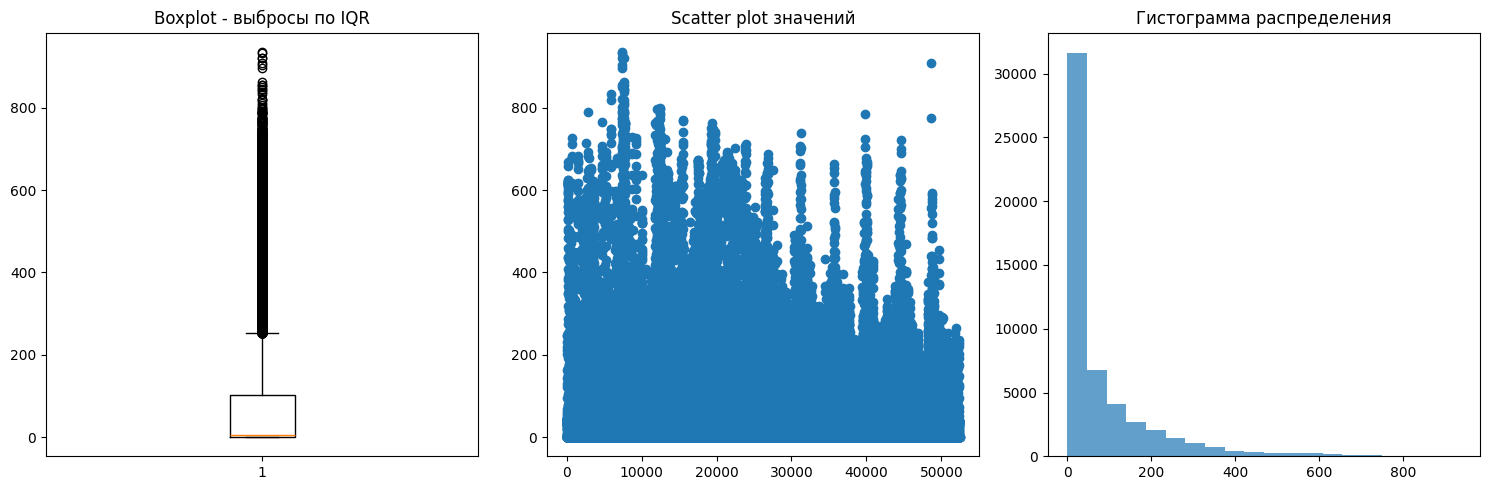

Обнаружено выбросов: 4571
Индексы выбросов: [4523, 4524, 4525, 4526, 4527, 4528, 4529, 4530, 4531, 4532, 4533, 4534, 4535, 4536, 4537, 4538, 4539, 4540, 4541, 4542, 4543, 4544, 4545, 4546, 4547, 4548, 4549, 4550, 4551, 4552, 4553, 4554, 4555, 4556, 4557, 4558, 4559, 4560, 4561, 4562, 4563, 4564, 4565, 4566, 4567, 8552, 8553, 8554, 8555, 8556, 8557, 8558, 8591, 8592, 8593, 8594, 8595, 8596, 8597, 8598, 8599, 8600, 8601, 17329, 17330, 17331, 17332, 17333, 17334, 17335, 17336, 17337, 17378, 17379, 17380, 17381, 17382, 17383, 17384, 17385, 17386, 17387, 17388, 17389, 17390, 21799, 21800, 21801, 21802, 21803, 21804, 21805, 21806, 21807, 21808, 21809, 21810, 21850, 21851, 21852, 21853, 21854, 26113, 26114, 26115, 26116, 26117, 26118, 26119, 26120, 26171, 26172, 26173, 26174, 26175, 30627, 30628, 30629, 30630, 30633, 30634, 30635, 30636, 30637, 43835, 43836, 43839, 43840, 43841, 43842, 43843, 43844, 43845, 43846, 43847, 43848, 43849, 43850, 43851, 43852, 43853, 43854, 43855, 43856, 43857, 438

In [20]:
df_clean = detect_and_handle_outliers(df_clean, 'DiffuseFlows')

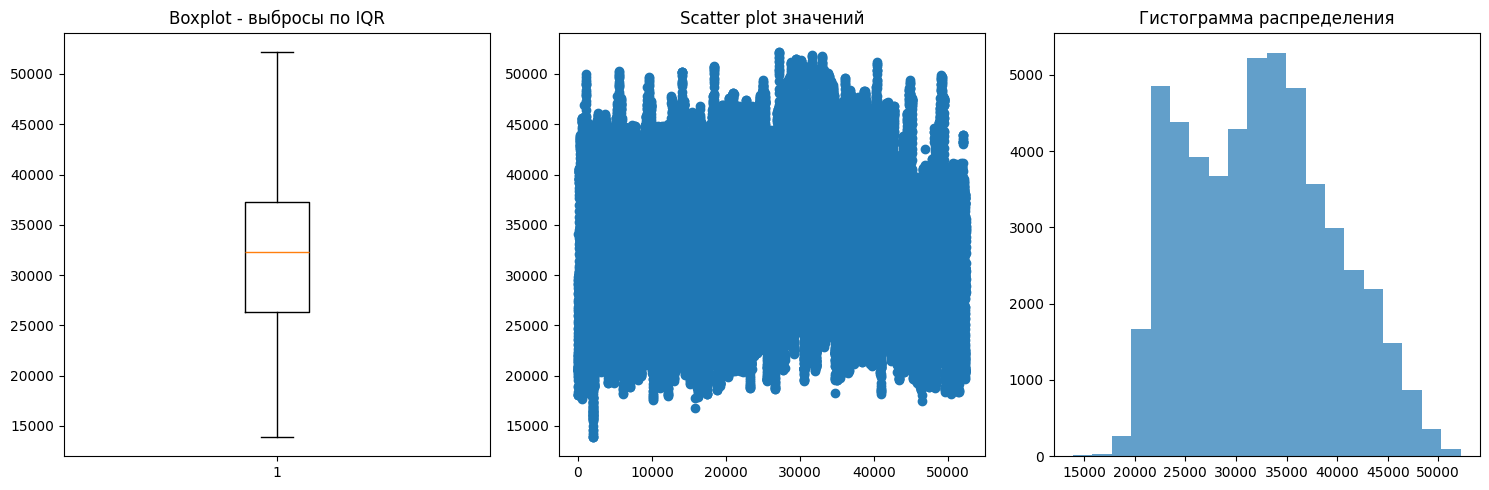

Обнаружено выбросов: 0


In [21]:
df_clean = detect_and_handle_outliers(df_clean, 'PowerConsumption_Zone1')

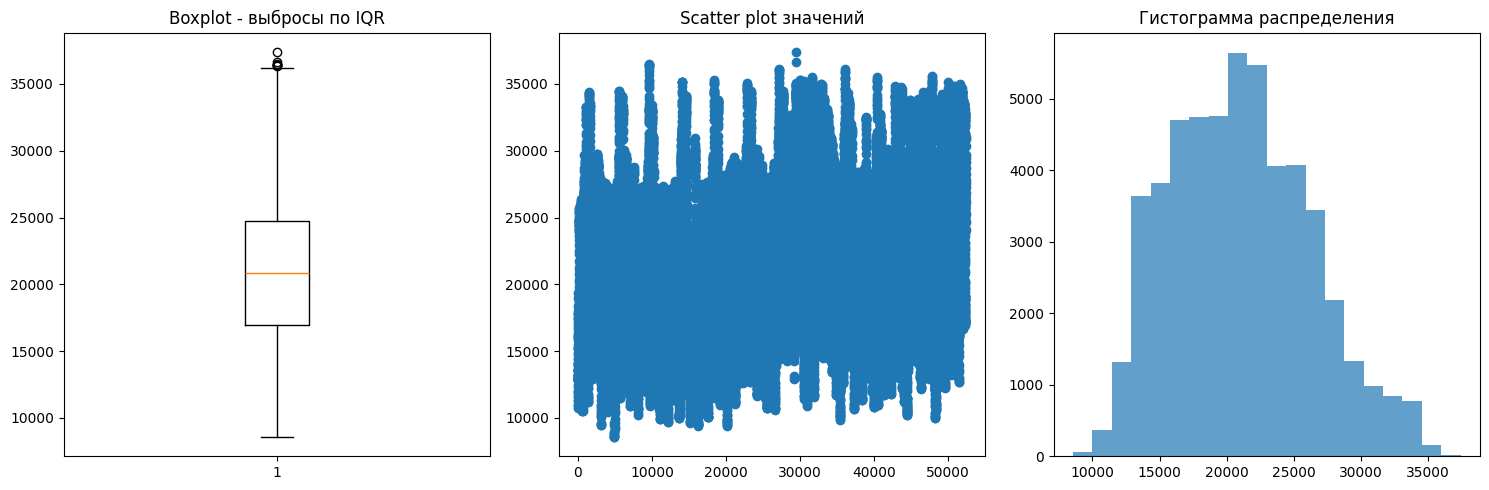

Обнаружено выбросов: 7
Индексы выбросов: [30935, 30936, 30937, 30938, 30939, 29493, 29494]
Выбросы заменены на граничные значения IQR


In [22]:
df_clean = detect_and_handle_outliers(df_clean, 'PowerConsumption_Zone2')

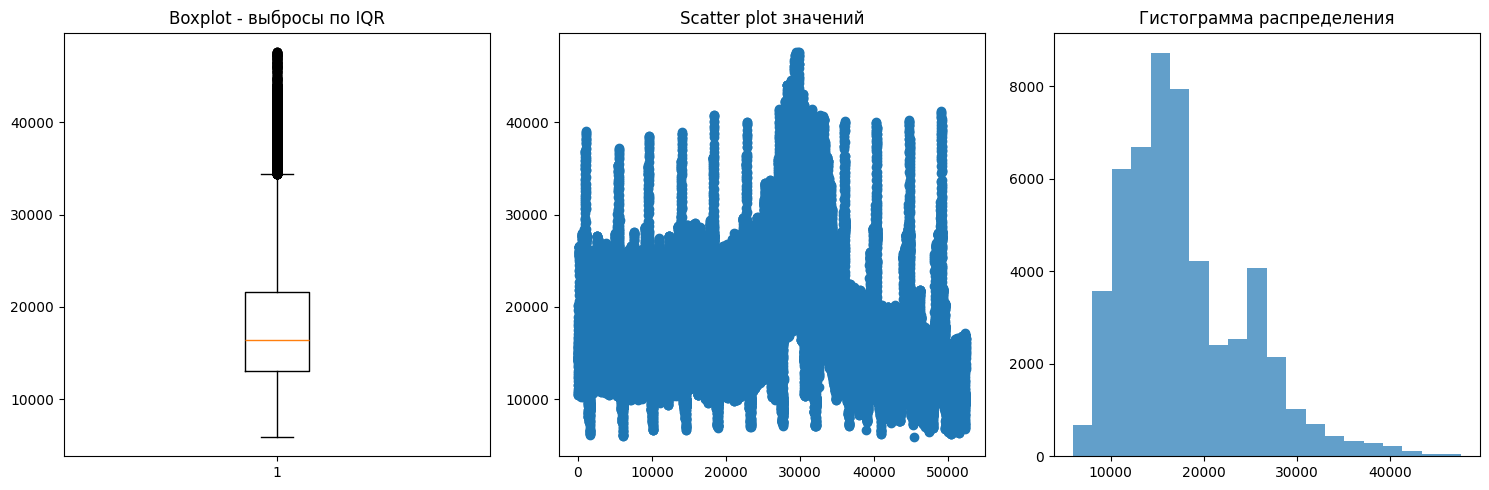

Обнаружено выбросов: 1191
Индексы выбросов: [26183, 26184, 26185, 26186, 26187, 26188, 26189, 26190, 26191, 26192, 26193, 26194, 26195, 26196, 26197, 30644, 30645, 30646, 30647, 30648, 30649, 30650, 30651, 30652, 30653, 30654, 30655, 30656, 30657, 30658, 30659, 30660, 30661, 30662, 30663, 30664, 26327, 26328, 26329, 26330, 26331, 26332, 26333, 26334, 26335, 26336, 26337, 30789, 30790, 30791, 30792, 30793, 30794, 30795, 30796, 30797, 30798, 30799, 30800, 30801, 30802, 26471, 26472, 26473, 26474, 26475, 26476, 26477, 26478, 26479, 26480, 26481, 26482, 30932, 30933, 30934, 30935, 30936, 30937, 30938, 30939, 30940, 30941, 30942, 30943, 30944, 30945, 30946, 30947, 30948, 30949, 30950, 26615, 26616, 26617, 26618, 26619, 26620, 26621, 26622, 26623, 26624, 26625, 26626, 31076, 31077, 31078, 31079, 31080, 31081, 31082, 31083, 31084, 31085, 31086, 31087, 31088, 31089, 31090, 31091, 31092, 31093, 31094, 31095, 26759, 26760, 26761, 26762, 26763, 26764, 26765, 26766, 26767, 26768, 26769, 26770, 267

In [23]:
df_clean = detect_and_handle_outliers(df_clean, 'PowerConsumption_Zone3')

### Этап 3. Описательный статистический анализ и визуализация
Задача: Получить первое впечатление о данных — распределениях, масштабах, аномалиях.

📊 Что нужно сделать:
- Рассчитать дескриптивную статистику для всех числовых столбцов:
  - Среднее, медиана, стандартное отклонение
  - Минимум, максимум, квартили
  - Коэффициенты асимметрии и эксцесса
- Построить:
  - Линейные графики целевой переменной и признаков по времени
  - Гистограммы и boxplot для каждого признака
  - Heatmap матрицы корреляций (Pearson / Spearman)
- Проанализировать:
  - Наличие сильных корреляций между признаками (мультиколлинеарность)
  - Наличие аномальных значений, неуловленных на этапе очистки

  
📈 Библиотеки: seaborn, matplotlib, plotly

Рассчитать дескриптивную статистику для всех числовых столбцов:
- Среднее, медиана, стандартное отклонение
- Минимум, максимум, квартили
- Коэффициенты асимметрии и эксцесса

In [28]:
def create_summary_table(df):
    """
    Создание сводной таблицы статистик для всех числовых столбцов
    """
    numeric_columns = df.select_dtypes(include=[np.number]).columns

    summary_data = []

    for col in numeric_columns:
        data = df[col].dropna()

        if len(data) == 0:
            continue

        summary_data.append({
            'Столбец': col,
            'N': len(data),
            'Пропуски': df[col].isna().sum(),
            'Среднее': np.mean(data),
            'Медиана': np.median(data),
            'Стд. отклонение': np.std(data, ddof=1),
            'Минимум': np.min(data),
            'Максимум': np.max(data),
            'Q1': np.percentile(data, 25),
            'Q3': np.percentile(data, 75),
            'Асимметрия': stats.skew(data),
            'Эксцесс': stats.kurtosis(data)
        })

    summary_df = pd.DataFrame(summary_data)

    float_columns = ['Среднее', 'Медиана', 'Стд. отклонение', 'Q1', 'Q3',
                    'Асимметрия', 'Эксцесс']

    for col in float_columns:
        if col in summary_df.columns:
            summary_df[col] = summary_df[col].round(4)

    return summary_df

summary_table = create_summary_table(df_clean)
print("\n" + "="*80)
print("СВОДНАЯ ТАБЛИЦА СТАТИСТИК")
print("="*80)
print(summary_table.to_string(index=False))


СВОДНАЯ ТАБЛИЦА СТАТИСТИК
               Столбец     N  Пропуски    Среднее    Медиана  Стд. отклонение      Минимум     Максимум         Q1         Q3  Асимметрия  Эксцесс
           Temperature 52416         0    18.8062    18.7800           5.8034     3.247000    35.610000    14.4100    22.8900      0.1804  -0.3621
              Humidity 52416         0    68.2860    69.8600          15.4689    23.675000    94.800000    58.3100    81.4000     -0.5904  -0.2646
             WindSpeed 52416         0     1.9595     0.0860           2.3489     0.050000     6.483000     0.0780     4.9150      0.4624  -1.7831
   GeneralDiffuseFlows 52416         0   180.1370     5.0355         257.9333     0.004000   798.907000     0.0620   319.6000      1.2428   0.1384
          DiffuseFlows 52416         0    62.1606     4.4560          85.0655     0.011000   252.317000     0.1220   101.0000      1.2059   0.0648
PowerConsumption_Zone1 52416         0 32344.9706 32265.9203        7130.5626 13895.696200 

Построить:
- Линейные графики целевой переменной и признаков по времени
- Гистограммы и boxplot для каждого признака
- Heatmap матрицы корреляций (Pearson / Spearman)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [30]:
df_clean.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,timestamp
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,2017-01-01 03:00:00+03:00
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,2017-01-01 03:10:00+03:00
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,2017-01-01 03:20:00+03:00
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,2017-01-01 03:30:00+03:00
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,2017-01-01 03:40:00+03:00


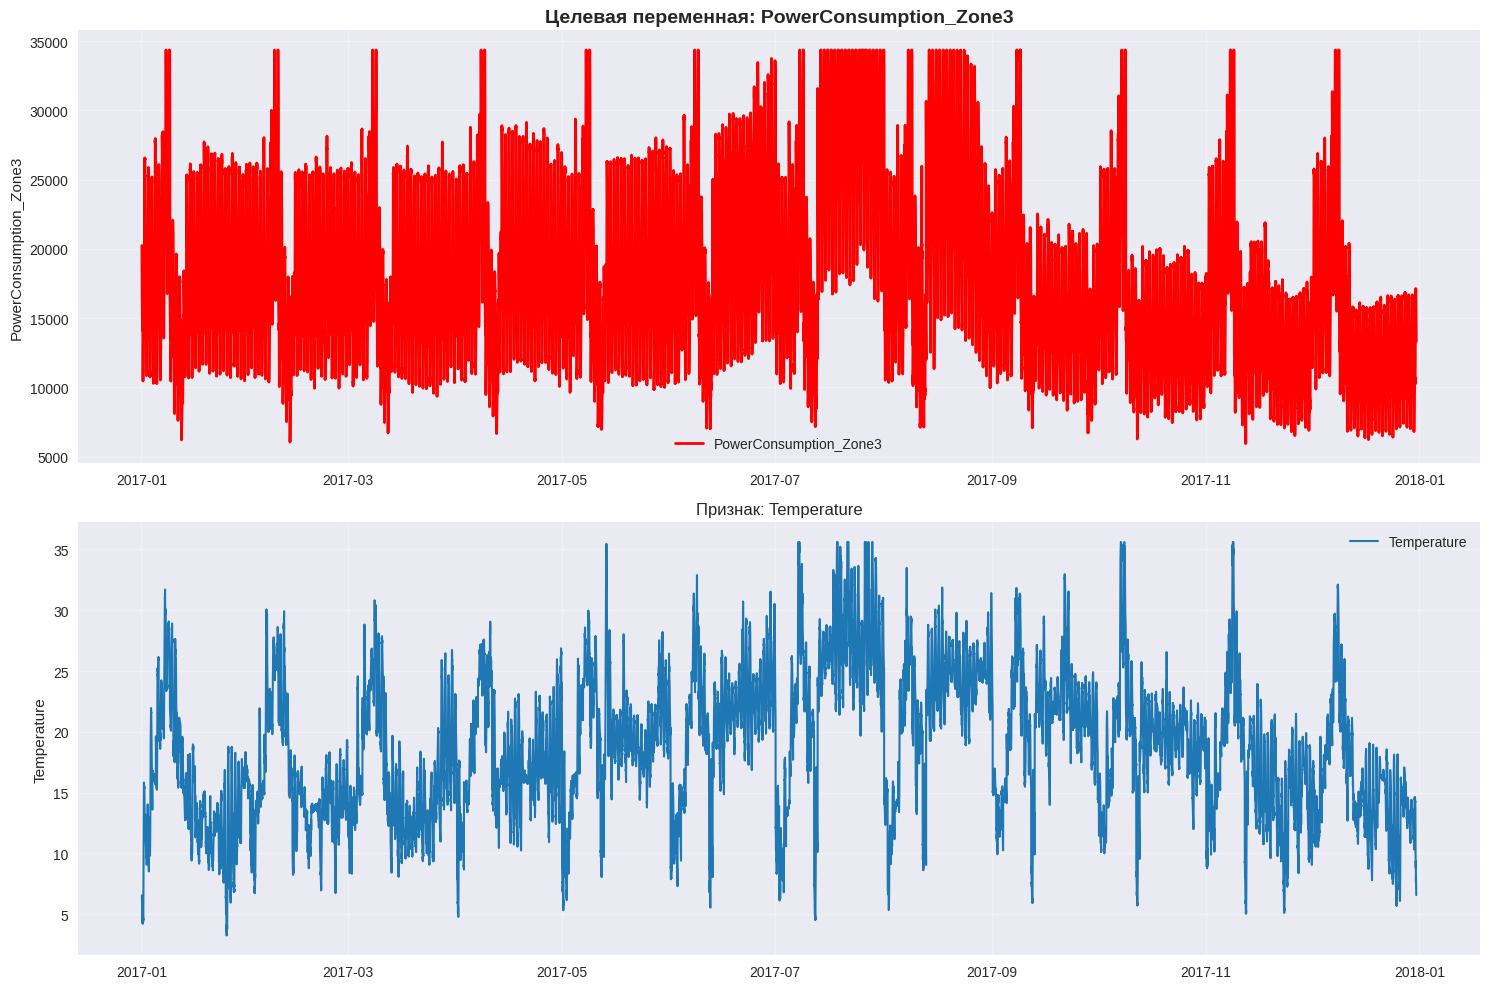

In [33]:
def plot_time_series(df, target_column, feature_columns=None, figsize=(15, 10)):
    """
    Построение линейных графиков целевой переменной и признаков по времени
    """
    time_index = df['timestamp']

    n_plots = 1 + len(feature_columns)
    fig, axes = plt.subplots(n_plots, 1, figsize=figsize)

    if n_plots == 1:
        axes = [axes]

    axes[0].plot(time_index, df[target_column], linewidth=2, color='red', label=target_column)
    axes[0].set_title(f'Целевая переменная: {target_column}', fontsize=14, fontweight='bold')
    axes[0].set_ylabel(target_column)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    colors = plt.cm.tab10(np.linspace(0, 1, len(feature_columns)))

    for i, (feature, color) in enumerate(zip(feature_columns, colors)):
        ax = axes[i + 1]
        ax.plot(time_index, df[feature], linewidth=1.5, color=color, label=feature)
        ax.set_title(f'Признак: {feature}', fontsize=12)
        ax.set_ylabel(feature)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Пример использования
plot_time_series(df_clean, 'PowerConsumption_Zone3', ['Temperature'])

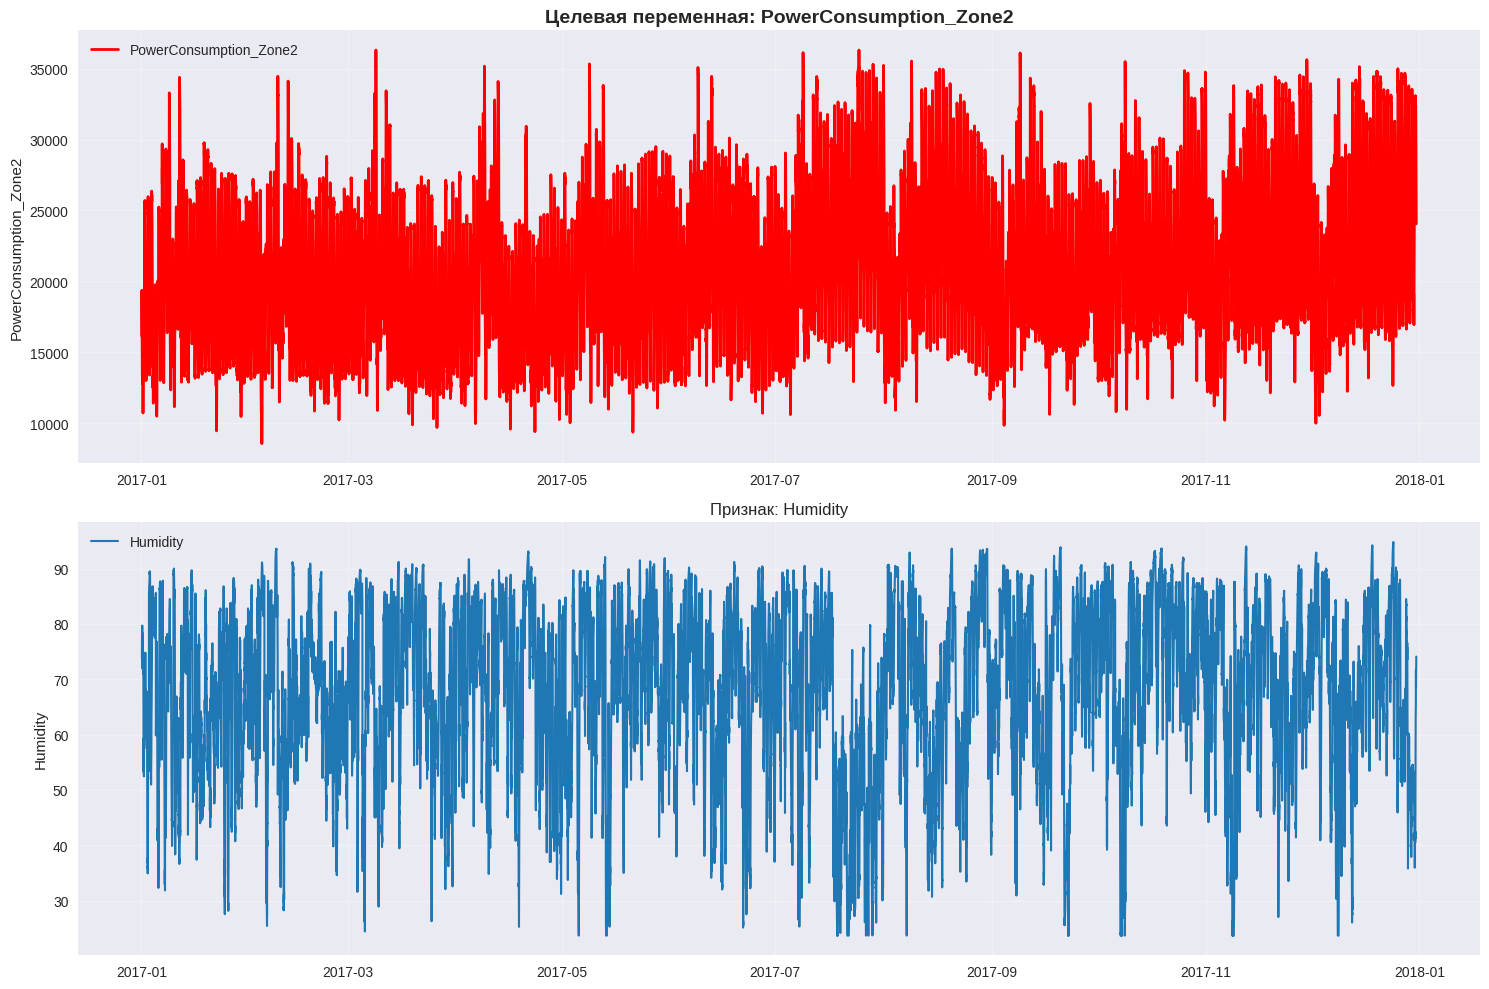

In [34]:
plot_time_series(df_clean, 'PowerConsumption_Zone2', ['Humidity'])

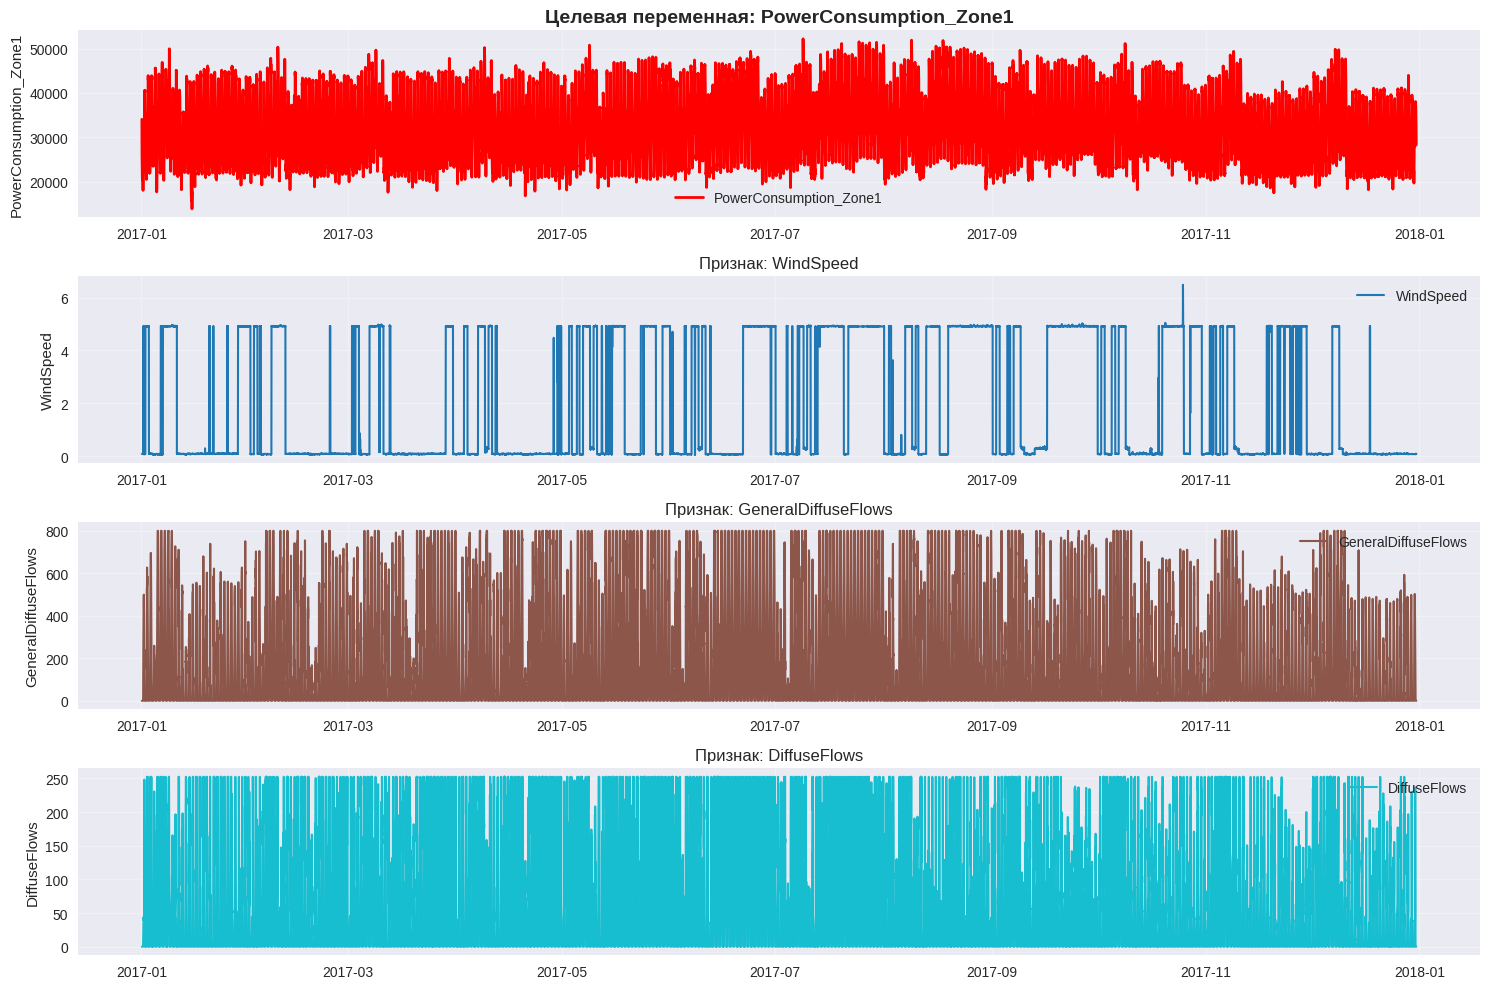

In [36]:
plot_time_series(df_clean, 'PowerConsumption_Zone1', ['WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows'])

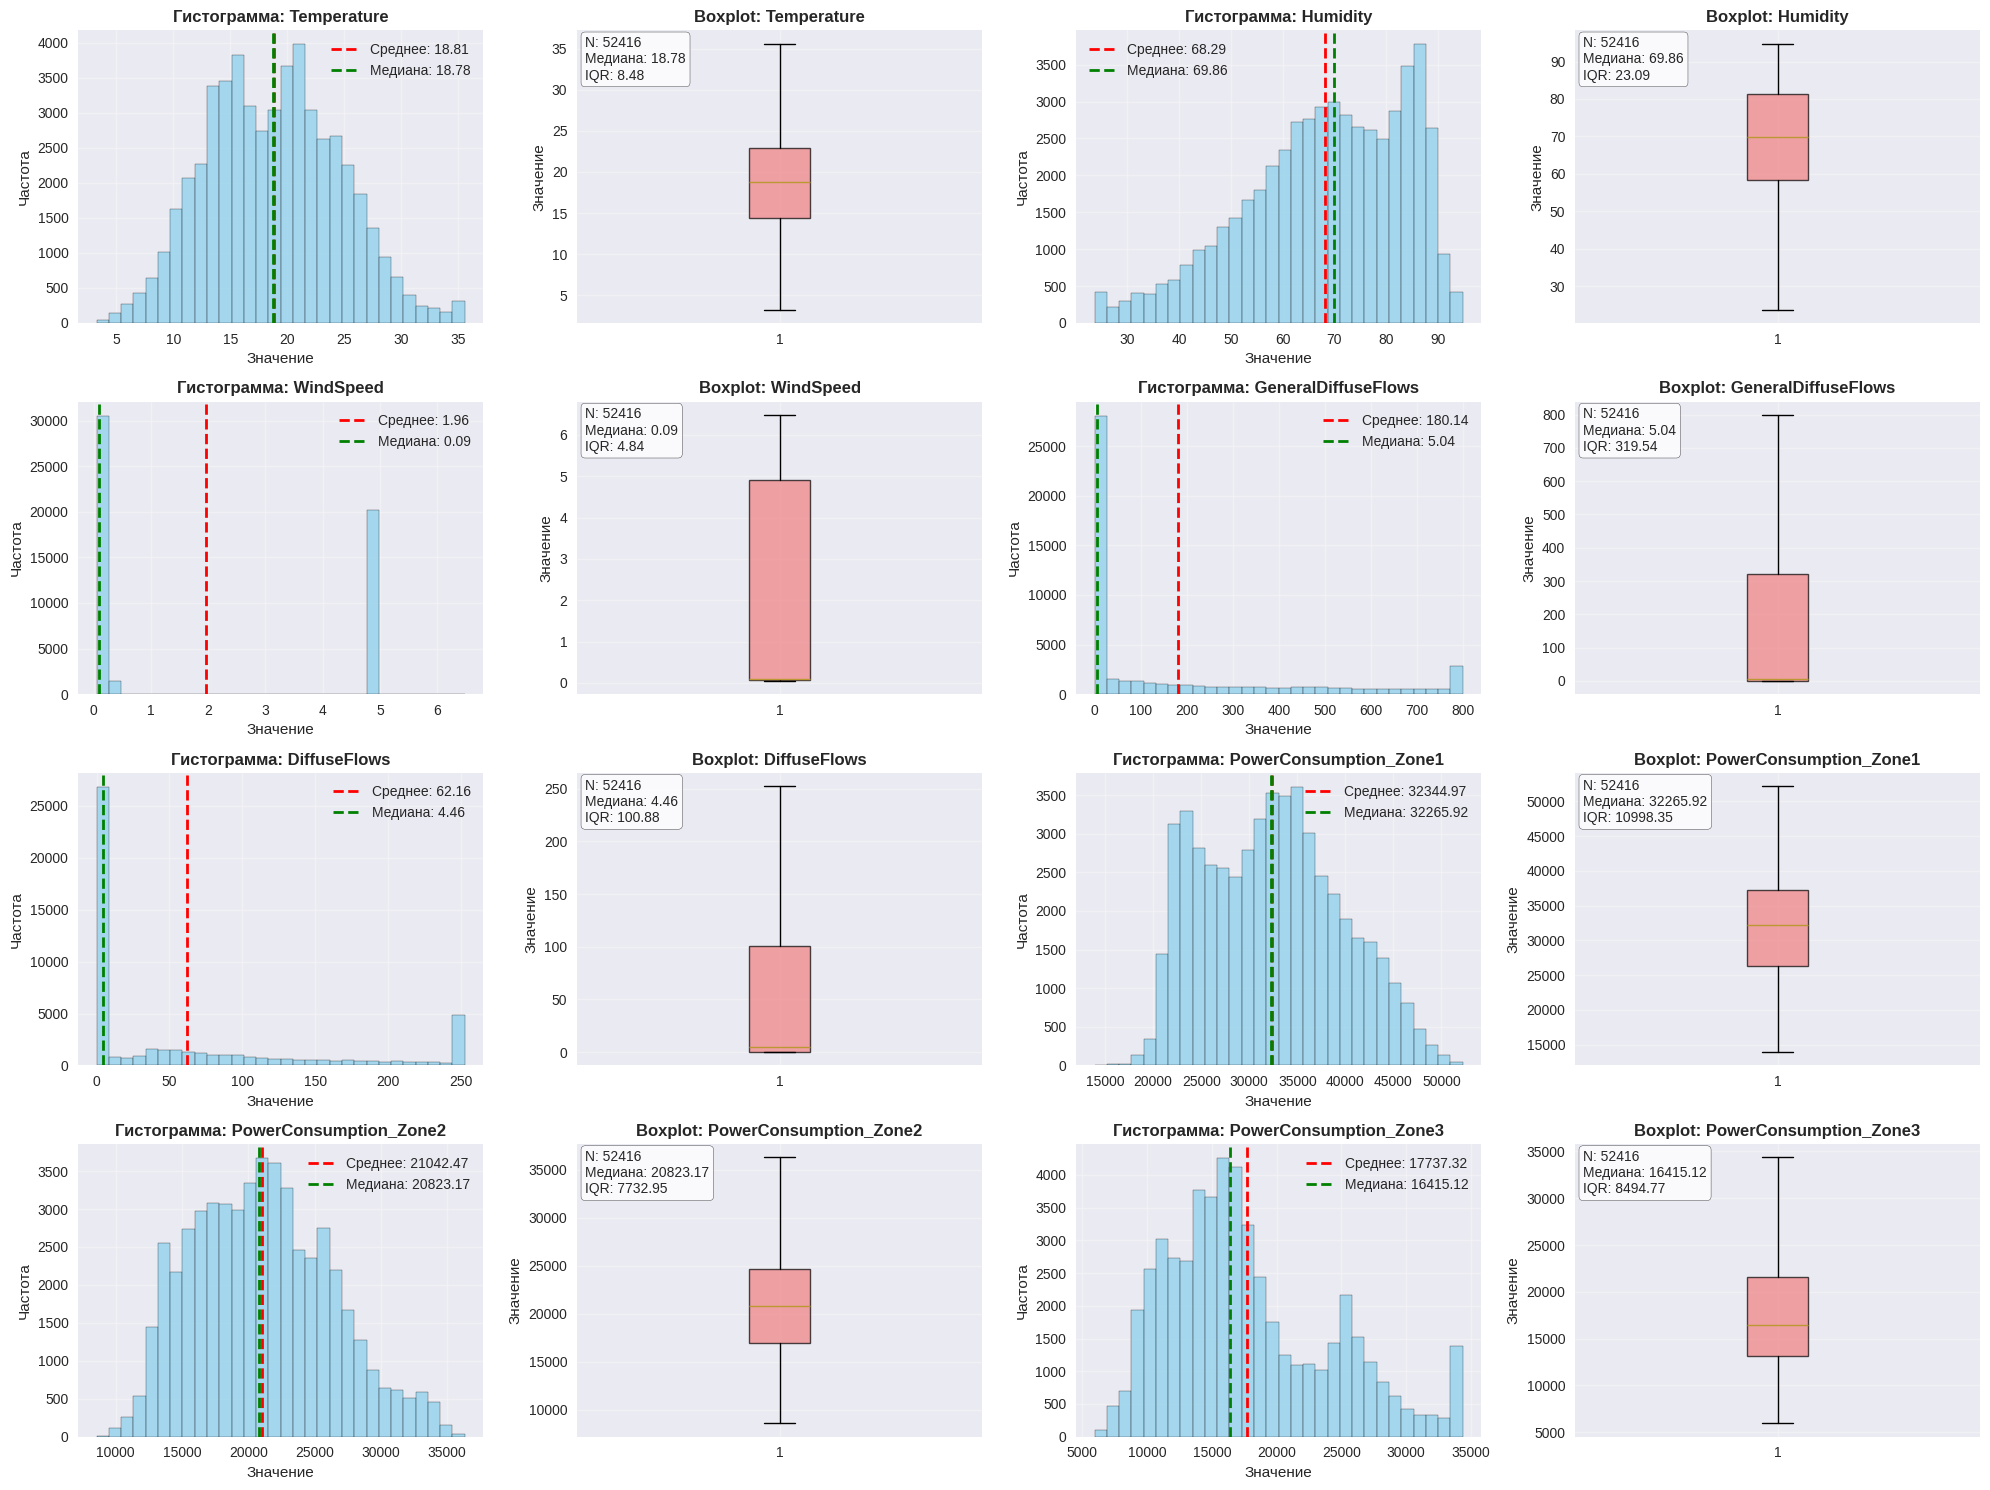

In [37]:
def plot_histograms_and_boxplots(df, target_column=None, figsize=(20, 15)):
    """
    Построение гистограмм и boxplot для всех числовых признаков
    """
    numeric_columns = df.select_dtypes(include=[np.number]).columns

    if len(numeric_columns) == 0:
        print("Нет числовых столбцов для визуализации")
        return

    n_cols = 4
    n_rows = (len(numeric_columns) * 2 + n_cols - 1) // n_cols

    fig = plt.figure(figsize=figsize)

    for i, column in enumerate(numeric_columns):
        data = df[column].dropna()

        ax1 = plt.subplot(n_rows, n_cols, 2*i + 1)
        n, bins, patches = ax1.hist(data, bins=min(30, len(data)//5),
                                   alpha=0.7, color='skyblue', edgecolor='black')

        ax1.axvline(data.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Среднее: {data.mean():.2f}')
        ax1.axvline(data.median(), color='green', linestyle='--', linewidth=2,
                   label=f'Медиана: {data.median():.2f}')

        ax1.set_title(f'Гистограмма: {column}', fontweight='bold')
        ax1.set_xlabel('Значение')
        ax1.set_ylabel('Частота')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        ax2 = plt.subplot(n_rows, n_cols, 2*i + 2)
        box_plot = ax2.boxplot(data, patch_artist=True,
                              boxprops=dict(facecolor='lightcoral', alpha=0.7))

        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        outliers = data[(data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)]

        if len(outliers) > 0:
            ax2.scatter([1]*len(outliers), outliers, color='red', alpha=0.6,
                       label=f'Выбросы: {len(outliers)}')

        ax2.set_title(f'Boxplot: {column}', fontweight='bold')
        ax2.set_ylabel('Значение')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        stats_text = f'N: {len(data)}\nМедиана: {data.median():.2f}\nIQR: {IQR:.2f}'
        ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()


plot_histograms_and_boxplots(df_clean, 'PowerConsumption_Zone1')

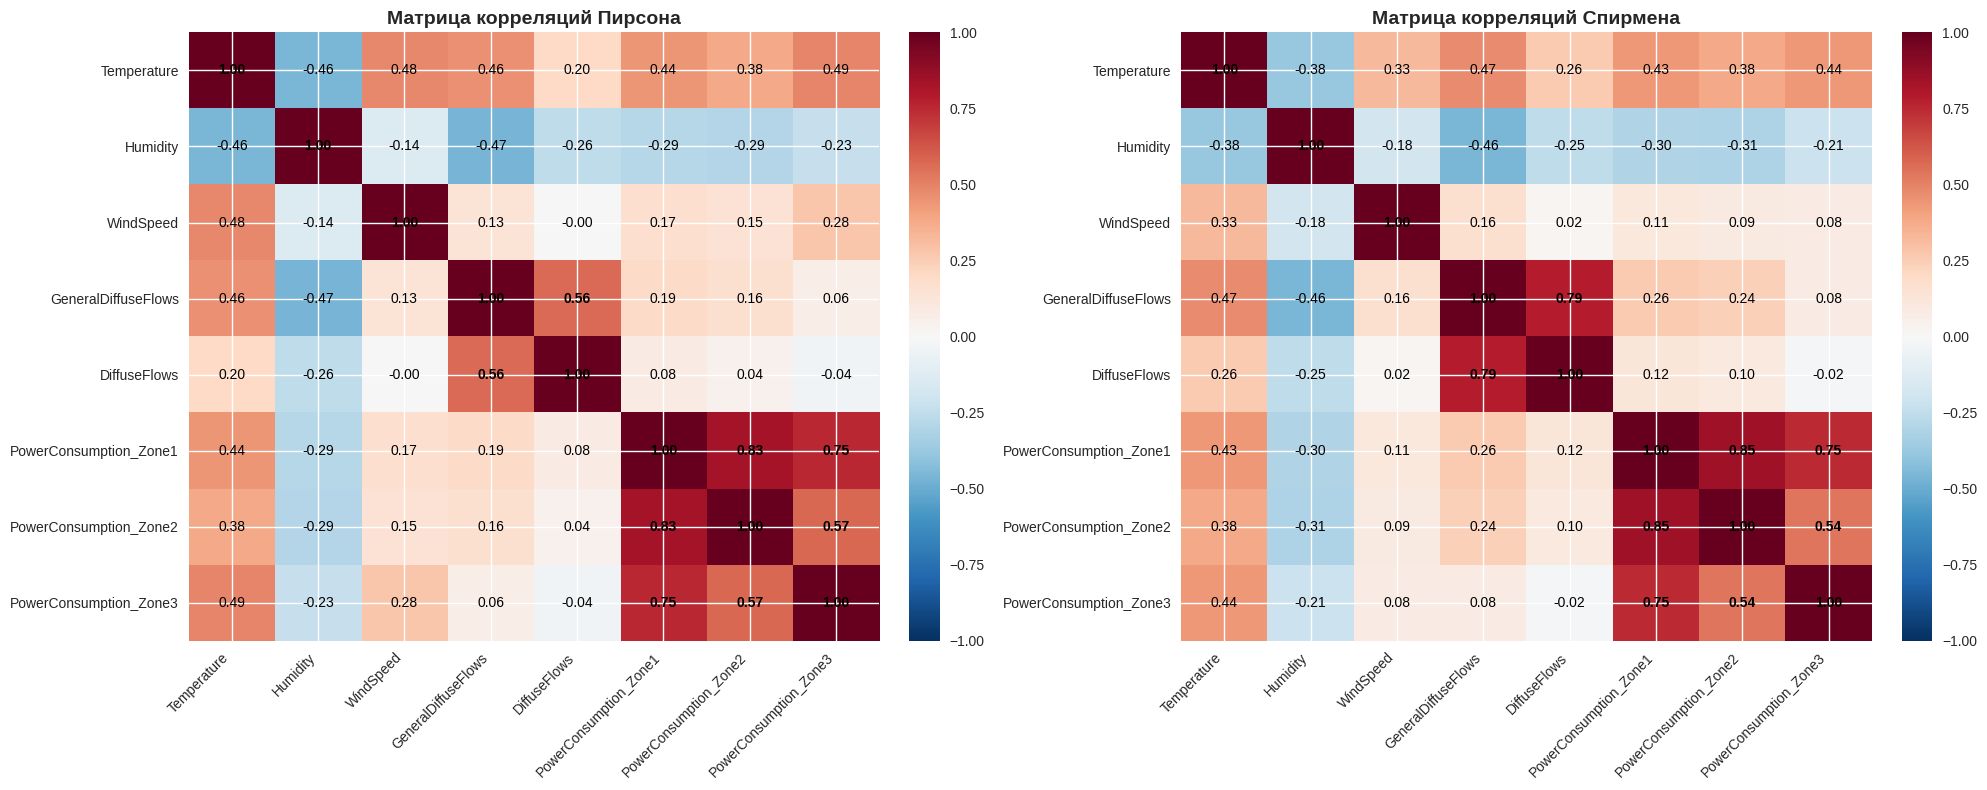

In [40]:
def plot_correlation_heatmaps(df, figsize=(20, 8)):
    """
    Построение heatmap матриц корреляций (Pearson и Spearman)
    """
    numeric_df = df.select_dtypes(include=[np.number])

    if len(numeric_df.columns) < 2:
        print("Недостаточно числовых столбцов для построения корреляций")
        return

    pearson_corr = numeric_df.corr(method='pearson')
    spearman_corr = numeric_df.corr(method='spearman')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Heatmap Pearson
    im1 = ax1.imshow(pearson_corr, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    ax1.set_title('Матрица корреляций Пирсона', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(pearson_corr.columns)))
    ax1.set_yticks(range(len(pearson_corr.columns)))
    ax1.set_xticklabels(pearson_corr.columns, rotation=45, ha='right')
    ax1.set_yticklabels(pearson_corr.columns)

    # Добавляем значения в ячейки для Pearson
    for i in range(len(pearson_corr.columns)):
        for j in range(len(pearson_corr.columns)):
            text = ax1.text(j, i, f'{pearson_corr.iloc[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=10,
                          fontweight='bold' if abs(pearson_corr.iloc[i, j]) > 0.5 else 'normal')

    # Heatmap Spearman
    im2 = ax2.imshow(spearman_corr, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    ax2.set_title('Матрица корреляций Спирмена', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(len(spearman_corr.columns)))
    ax2.set_yticks(range(len(spearman_corr.columns)))
    ax2.set_xticklabels(spearman_corr.columns, rotation=45, ha='right')
    ax2.set_yticklabels(spearman_corr.columns)

    # Добавляем значения в ячейки для Spearman
    for i in range(len(spearman_corr.columns)):
        for j in range(len(spearman_corr.columns)):
            text = ax2.text(j, i, f'{spearman_corr.iloc[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=10,
                          fontweight='bold' if abs(spearman_corr.iloc[i, j]) > 0.5 else 'normal')

    # Цветовая шкала
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

plot_correlation_heatmaps(df)

Сильной корелляции между признаками нет.

### Этап 4. Проверка на стационарность и статистические тесты
Задача: Определить, является ли ряд стационарным — ключевое требование для классических методов анализа.

📌 Что нужно сделать:
- Визуальный анализ: есть ли тренд, меняется ли дисперсия во времени?
- Рассчитать скользящее среднее и скользящую дисперсию (по окнам 30, 60, 90 точек) — стабильны ли они?
- Применить статистические тесты:
  - Тест Дики-Фуллера (ADF) — нулевая гипотеза: ряд имеет единичный корень (нестационарен)
  - Тест KPSS — нулевая гипотеза: ряд стационарен
- Интерпретировать p-value:
  - ADF: p < 0.05 → ряд стационарен
  - KPSS: p > 0.05 → ряд стационарен


Если ряд нестационарен — применить дифференцирование 1-го порядка и повторить тесты


📚 Библиотеки: statsmodels.tsa.stattools.adfuller, kpss

In [ ]:
series_timeindex = pd.Series(
    data=df_clean['PowerConsumption_Zone2'].values,
    index=df_clean['timestamp']
)

📊 АНАЛИЗ СТАЦИОНАРНОСТИ ВРЕМЕННОГО РЯДА
Длина ряда: 52416
Период анализа: 2017-01-01 03:00:00+03:00 - 2017-12-31 02:50:00+03:00

👁️ ВИЗУАЛЬНЫЙ АНАЛИЗ:
----------------------------------------
Окно 30: Среднее изм. +100.4% (❌ НЕСТАБИЛЬНО), Стд. изм. +29.6% (❌ НЕСТАБИЛЬНО)
Окно 60: Среднее изм. +109.1% (❌ НЕСТАБИЛЬНО), Стд. изм. +56.2% (❌ НЕСТАБИЛЬНО)
Окно 90: Среднее изм. +81.9% (❌ НЕСТАБИЛЬНО), Стд. изм. +35.4% (❌ НЕСТАБИЛЬНО)


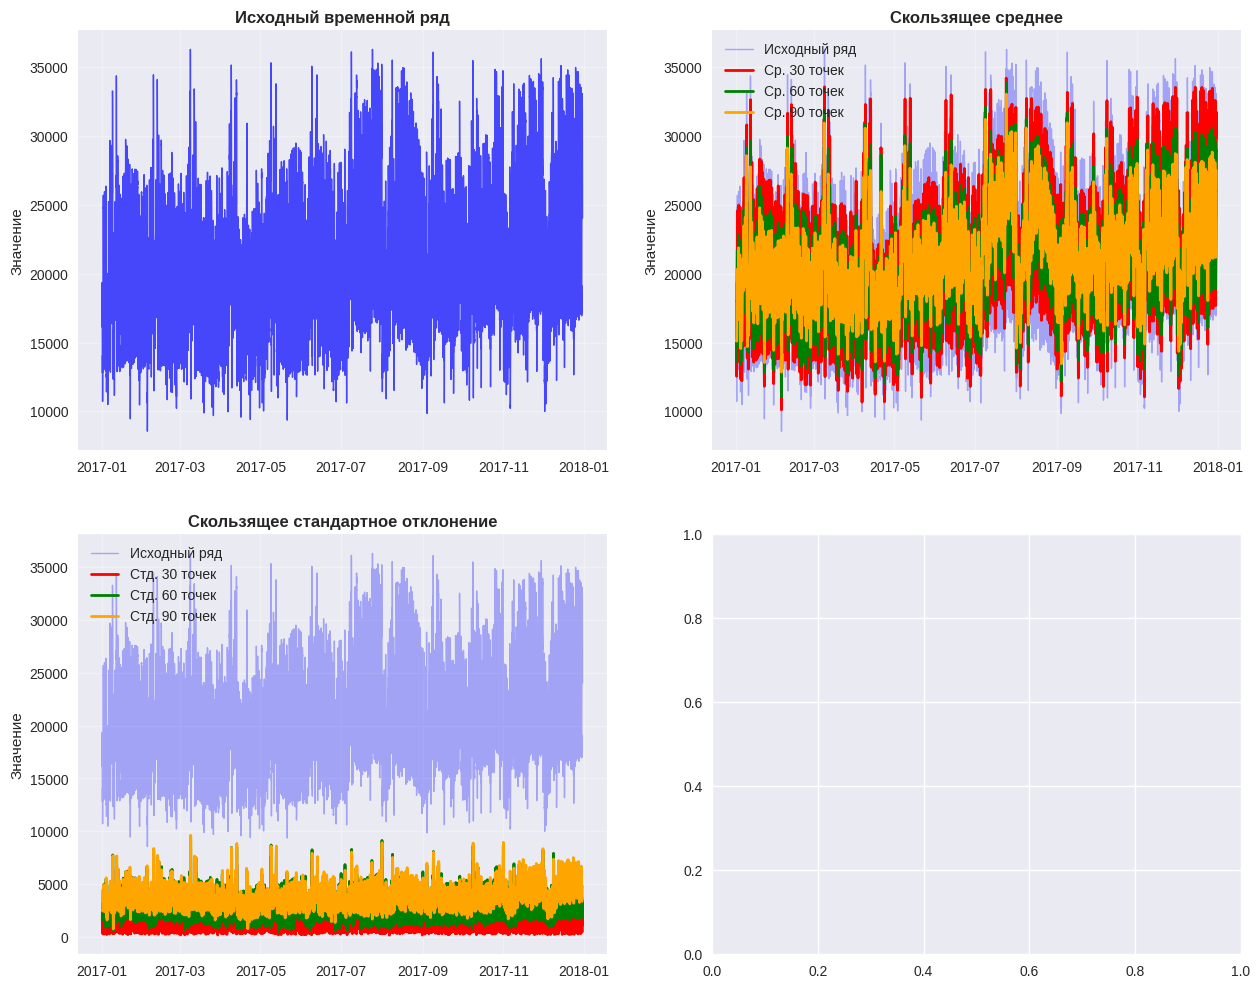

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

def analyze_stationarity(series, window_sizes=[30, 60, 90], figsize=(15, 12)):
    """
    Комплексный анализ стационарности временного ряда
    """
    print("📊 АНАЛИЗ СТАЦИОНАРНОСТИ ВРЕМЕННОГО РЯДА")
    print("="*60)

    print(f"Длина ряда: {len(series)}")
    print(f"Период анализа: {series.index[0]} - {series.index[-1]}")

    visual_analysis(series, window_sizes, figsize)


def visual_analysis(series, window_sizes, figsize):
    """
    Визуальный анализ стационарности
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()

    # 1. Исходный ряд
    axes[0].plot(series.index, series.values, linewidth=1, color='blue', alpha=0.7)
    axes[0].set_title('Исходный временной ряд', fontweight='bold')
    axes[0].set_ylabel('Значение')
    axes[0].grid(True, alpha=0.3)

    # 2. Скользящее среднее для разных окон
    colors = ['red', 'green', 'orange']
    axes[1].plot(series.index, series.values, linewidth=1, color='blue', alpha=0.3, label='Исходный ряд')

    for i, window in enumerate(window_sizes):
        if window < len(series):
            rolling_mean = series.rolling(window=window, center=True).mean()
            axes[1].plot(rolling_mean.index, rolling_mean.values,
                       linewidth=2, color=colors[i], label=f'Ср. {window} точек')

    axes[1].set_title('Скользящее среднее', fontweight='bold')
    axes[1].set_ylabel('Значение')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # 3. Скользящая дисперсия
    axes[2].plot(series.index, series.values, linewidth=1, color='blue', alpha=0.3, label='Исходный ряд')

    for i, window in enumerate(window_sizes):
        if window < len(series):
            rolling_std = series.rolling(window=window, center=True).std()
            axes[2].plot(rolling_std.index, rolling_std.values,
                       linewidth=2, color=colors[i], label=f'Стд. {window} точек')

    axes[2].set_title('Скользящее стандартное отклонение', fontweight='bold')
    axes[2].set_ylabel('Значение')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    # Анализ результатов визуального осмотра
    print("\n👁️ ВИЗУАЛЬНЫЙ АНАЛИЗ:")
    print("-" * 40)

    # Анализ скользящего среднего
    analysis_results = []
    for window in window_sizes:
        if window < len(series):
            rolling_mean = series.rolling(window=window).mean().dropna()
            rolling_std = series.rolling(window=window).std().dropna()

            mean_change = (rolling_mean.iloc[-1] - rolling_mean.iloc[0]) / rolling_mean.iloc[0] * 100
            std_change = (rolling_std.iloc[-1] - rolling_std.iloc[0]) / rolling_std.iloc[0] * 100

            analysis_results.append({
                'window': window,
                'mean_change_pct': mean_change,
                'std_change_pct': std_change,
                'mean_stable': abs(mean_change) < 10,  # менее 10% изменения
                'std_stable': abs(std_change) < 20     # менее 20% изменения
            })

            status_mean = "✅ СТАБИЛЬНО" if abs(mean_change) < 10 else "❌ НЕСТАБИЛЬНО"
            status_std = "✅ СТАБИЛЬНО" if abs(std_change) < 20 else "❌ НЕСТАБИЛЬНО"

            print(f"Окно {window}: Среднее изм. {mean_change:+.1f}% ({status_mean}), "
                  f"Стд. изм. {std_change:+.1f}% ({status_std})")

    return analysis_results


analyze_stationarity(series_timeindex)

Применить статистические тесты:
  - Тест Дики-Фуллера (ADF) — нулевая гипотеза: ряд имеет единичный корень (нестационарен)
  - Тест KPSS — нулевая гипотеза: ряд стационарен

Интерпретировать p-value:
  - ADF: p < 0.05 → ряд стационарен
  - KPSS: p > 0.05 → ряд стационарен

In [45]:
from statsmodels.tsa.stattools import adfuller, kpss

def check_stationarity(series):
    """
    Проверка стационарности с помощью ADF и KPSS тестов
    """
    print("📊 СТАТИСТИЧЕСКИЕ ТЕСТЫ СТАЦИОНАРНОСТИ")
    print("=" * 50)

    # ADF тест (нулевая гипотеза: ряд нестационарен)
    adf_result = adfuller(series.dropna())
    adf_pvalue = adf_result[1]

    # KPSS тест (нулевая гипотеза: ряд стационарен)
    kpss_result = kpss(series.dropna(), regression='c')
    kpss_pvalue = kpss_result[1]

    print(f"ADF тест: p-value = {adf_pvalue:.4f}")
    print(f"KPSS тест: p-value = {kpss_pvalue:.4f}")
    print("-" * 30)

    # Интерпретация ADF
    if adf_pvalue < 0.05:
        print("✅ ADF: p < 0.05 → ОТВЕРГАЕМ H0 → ряд СТАЦИОНАРЕН")
    else:
        print("❌ ADF: p ≥ 0.05 → НЕ ОТВЕРГАЕМ H0 → ряд НЕСТАЦИОНАРЕН")

    # Интерпретация KPSS
    if kpss_pvalue > 0.05:
        print("✅ KPSS: p > 0.05 → НЕ ОТВЕРГАЕМ H0 → ряд СТАЦИОНАРЕН")
    else:
        print("❌ KPSS: p ≤ 0.05 → ОТВЕРГАЕМ H0 → ряд НЕСТАЦИОНАРЕН")

    # Сводный вывод
    print("-" * 30)
    if adf_pvalue < 0.05 and kpss_pvalue > 0.05:
        print("🎯 ВЫВОД: Оба теста подтверждают СТАЦИОНАРНОСТЬ")
    elif adf_pvalue >= 0.05 and kpss_pvalue <= 0.05:
        print("🎯 ВЫВОД: Оба теста подтверждают НЕСТАЦИОНАРНОСТЬ")
    else:
        print("🎯 ВЫВОД: Противоречивые результаты - ряд может быть стационарен вокруг тренда")

check_stationarity(series_timeindex)

📊 СТАТИСТИЧЕСКИЕ ТЕСТЫ СТАЦИОНАРНОСТИ
ADF тест: p-value = 0.0000
KPSS тест: p-value = 0.0100
------------------------------
✅ ADF: p < 0.05 → ОТВЕРГАЕМ H0 → ряд СТАЦИОНАРЕН
❌ KPSS: p ≤ 0.05 → ОТВЕРГАЕМ H0 → ряд НЕСТАЦИОНАРЕН
------------------------------
🎯 ВЫВОД: Противоречивые результаты - ряд может быть стационарен вокруг тренда


Дифференцирование ряда

In [65]:
def differentiate_series(series, order=1):
    if order < 1:
        raise ValueError("Порядок дифференцирования должен быть >= 1")

    differentiated = series.diff(periods=order)

    return differentiated

diff_time_series = differentiate_series(series_timeindex, order=1)
check_stationarity(diff_time_series)

📊 СТАТИСТИЧЕСКИЕ ТЕСТЫ СТАЦИОНАРНОСТИ
ADF тест: p-value = 0.0000
KPSS тест: p-value = 0.1000
------------------------------
✅ ADF: p < 0.05 → ОТВЕРГАЕМ H0 → ряд СТАЦИОНАРЕН
✅ KPSS: p > 0.05 → НЕ ОТВЕРГАЕМ H0 → ряд СТАЦИОНАРЕН
------------------------------
🎯 ВЫВОД: Оба теста подтверждают СТАЦИОНАРНОСТЬ


### Этап 5. Создание лаговых признаков и скользящих статистик
Задача: Подготовить данные для анализа временных зависимостей.

⏳ Что нужно сделать:
- Создать лаги целевой переменной: target_lag_1, target_lag_7, target_lag_30
- Создать лаги для значимых признаков (если есть гипотеза о запаздывании влияния)
- Рассчитать скользящие статистики:
  - Скользящее среднее: target_rolling_mean_7, target_rolling_mean_30
  - Скользящее стандартное отклонение: target_rolling_std_7
- Проверить корреляцию между лагами и целевой переменной — какие лаги наиболее информативны?
- Проверить мультиколлинеарность после добавления лагов

💡 Совет: используйте df.shift() и df.rolling() в pandas

In [50]:
import pandas as pd

def create_lags(df, target_column, lags=[1, 7, 30]):
    """
    Создание лагов для целевой переменной и признаков
    """
    df_lagged = df.copy()

    for lag in lags:
        df_lagged[f'{target_column}_lag_{lag}'] = df_lagged[target_column].shift(lag)

    df_lagged = df_lagged.dropna()

    print(f"✅ Созданы лаги: {lags}")
    print(f"📊 Размер данных до: {len(df)}, после: {len(df_lagged)}")

    return df_lagged


df_with_lags = create_lags(df_clean, target_column='PowerConsumption_Zone1', lags=[1, 7, 30])

print(df_with_lags[['PowerConsumption_Zone1', 'PowerConsumption_Zone1_lag_1', 'PowerConsumption_Zone1_lag_7', 'PowerConsumption_Zone1_lag_30']].head(10))

✅ Созданы лаги: [1, 7, 30]
📊 Размер данных до: 52416, после: 52386
    PowerConsumption_Zone1  PowerConsumption_Zone1_lag_1  \
30             20542.78481                   20311.89873   
31             20621.77215                   20542.78481   
32             20627.84810                   20621.77215   
33             20797.97468                   20627.84810   
34             20858.73418                   20797.97468   
35             21393.41772                   20858.73418   
36             22219.74684                   21393.41772   
37             21928.10127                   22219.74684   
38             21776.20253                   21928.10127   
39             21654.68354                   21776.20253   

    PowerConsumption_Zone1_lag_7  PowerConsumption_Zone1_lag_30  
30                   20421.26582                    34055.69620  
31                   20524.55696                    29814.68354  
32                   20482.02532                    29128.10127  
33      

In [53]:
def create_rolling_features(df, target_column, windows=[7, 30]):
    """
    Создание скользящих статистик для целевой переменной
    """
    df_rolling = df.copy()

    # Скользящее среднее
    for window in windows:
        df_rolling[f'{target_column}_rolling_mean_{window}'] = df_rolling[target_column].rolling(window=window).mean()

    # Скользящее стандартное отклонение
    df_rolling[f'{target_column}_rolling_std_7'] = df_rolling[target_column].rolling(window=7).std()

    # Удаляем строки с NaN (из-за скользящего окна)
    df_rolling = df_rolling.dropna()

    print(f"✅ Созданы скользящие статистики для окна 7 и 30")
    print(f"📊 Размер данных до: {len(df)}, после: {len(df_rolling)}")

    return df_rolling

# Использование
df_with_rolling = create_rolling_features(df_clean, target_column='PowerConsumption_Zone1')

# Проверка результата
print(df_with_rolling[['PowerConsumption_Zone1',
                       'PowerConsumption_Zone1_rolling_mean_7',
                       'PowerConsumption_Zone1_rolling_mean_30',
                       'PowerConsumption_Zone1_rolling_std_7']].head(10))

✅ Созданы скользящие статистики для окна 7 и 30
📊 Размер данных до: 52416, после: 52387
    PowerConsumption_Zone1  PowerConsumption_Zone1_rolling_mean_7  \
29             20311.89873                           20468.137431   
30             20542.78481                           20485.497287   
31             20621.77215                           20499.385171   
32             20627.84810                           20520.216997   
33             20797.97468                           20558.408679   
34             20858.73418                           20607.884267   
35             21393.41772                           20736.347196   
36             22219.74684                           21008.896926   
37             21928.10127                           21206.799277   
38             21776.20253                           21371.717903   

    PowerConsumption_Zone1_rolling_mean_30  \
29                            23445.063291   
30                            22994.632911   
31            

Проверить корреляцию между лагами и целевой переменной — какие лаги наиболее информативны?


Проверить мультиколлинеарность после добавления лагов

In [55]:
lag_columns = [col for col in df_with_lags.columns if 'lag' in col]
correlation_with_target = df_with_lags[lag_columns + ['PowerConsumption_Zone1']].corr()['PowerConsumption_Zone1'].sort_values(ascending=False)

print("📊 КОРРЕЛЯЦИЯ ЛАГОВ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:")
print("=" * 50)
for lag, corr in correlation_with_target.items():
    if lag != 'PowerConsumption_Zone1':
        print(f"{lag}: {corr:.3f}")

from statsmodels.stats.outliers_influence import variance_inflation_factor

def check_vif(df, features):
    """Проверка VIF для мультиколлинеарности"""
    from statsmodels.tools.tools import add_constant
    X = add_constant(df[features])

    vif_data = []
    for i, col in enumerate(X.columns):
        if col != 'const':
            vif = variance_inflation_factor(X.values, i)
            vif_data.append({'feature': col, 'vif': vif})

    vif_df = pd.DataFrame(vif_data).sort_values('vif', ascending=False)
    return vif_df

lag_features = [col for col in df_with_lags.columns if 'lag' in col]
vif_results = check_vif(df_with_lags, lag_features)

print("\n🔍 МУЛЬТИКОЛЛИНЕАРНОСТЬ ЛАГОВ (VIF):")
print("=" * 50)
for _, row in vif_results.iterrows():
    status = "⚠️ ВЫСОКИЙ" if row['vif'] > 10 else "✅ НОРМАЛЬНЫЙ" if row['vif'] <= 5 else "🔶 УМЕРЕННЫЙ"
    print(f"{row['feature']}: {row['vif']:.1f} - {status}")

📊 КОРРЕЛЯЦИЯ ЛАГОВ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:
PowerConsumption_Zone1_lag_1: 0.996
PowerConsumption_Zone1_lag_7: 0.884
PowerConsumption_Zone1_lag_30: 0.131

🔍 МУЛЬТИКОЛЛИНЕАРНОСТЬ ЛАГОВ (VIF):
PowerConsumption_Zone1_lag_7: 7.6 - 🔶 УМЕРЕННЫЙ
PowerConsumption_Zone1_lag_1: 6.8 - 🔶 УМЕРЕННЫЙ
PowerConsumption_Zone1_lag_30: 1.3 - ✅ НОРМАЛЬНЫЙ


### Этап 6. Анализ автокорреляции: ACF и PACF
Задача: Выявить структуру зависимости ряда от собственного прошлого.

📈 Что нужно сделать:
- Построить и визуализировать:
  - ACF (Autocorrelation Function) — корреляция ряда с его лагами (включая косвенные зависимости)
  - PACF (Partial Autocorrelation Function) — “чистая” корреляция с лагом, исключая влияние промежуточных лагов
- Интерпретировать графики:
  - Резкий обрыв в PACF на лаге p → возможный порядок AR(p)
  - Постепенное затухание в ACF → возможный порядок MA(q)

- Указать, какие лаги статистически значимы (выходят за доверительный интервал)

📊 Библиотеки: statsmodels.graphics.tsaplots.plot_acf, plot_pacf

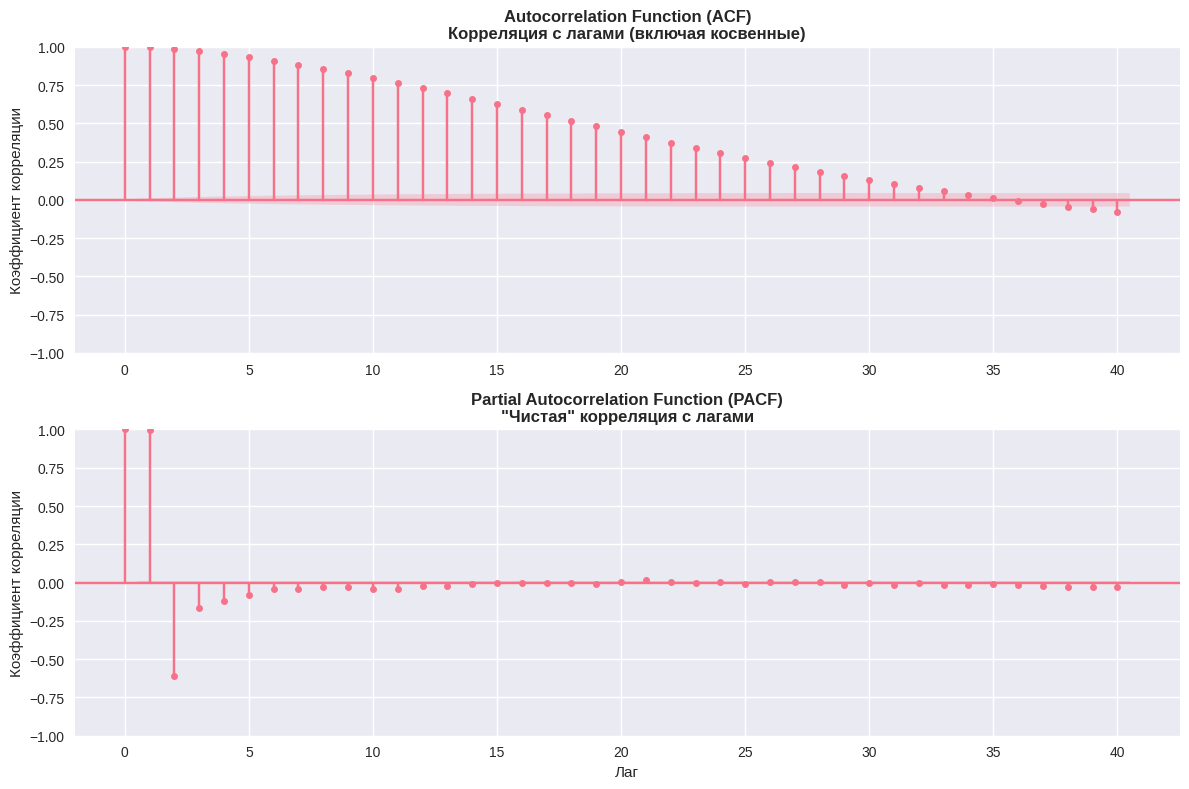

In [57]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def plot_acf_pacf(series, lags=40):
    """
    Построение ACF и PACF для анализа автокорреляции
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # ACF - автокорреляционная функция
    plot_acf(series, ax=ax1, lags=lags, alpha=0.05)
    ax1.set_title('Autocorrelation Function (ACF)\nКорреляция с лагами (включая косвенные)',
                  fontweight='bold')
    ax1.set_ylabel('Коэффициент корреляции')

    # PACF - частная автокорреляционная функция
    plot_pacf(series, ax=ax2, lags=lags, alpha=0.05, method='ywm')
    ax2.set_title('Partial Autocorrelation Function (PACF)\n"Чистая" корреляция с лагами',
                  fontweight='bold')
    ax2.set_ylabel('Коэффициент корреляции')
    ax2.set_xlabel('Лаг')

    plt.tight_layout()
    plt.show()

plot_acf_pacf(df_with_lags['PowerConsumption_Zone1'], lags=40)

### Этап 7. Декомпозиция временного ряда
Задача: Разделить ряд на составляющие — чтобы понять, что “движет” данными.

🧩 Что нужно сделать:
- Применить декомпозицию:
  - Аддитивную: value = trend + seasonality + residual
  - Мультипликативную: value = trend × seasonality × residual — если амплитуда сезонности растёт со временем
  - Визуализировать каждую компоненту отдельно
- Проанализировать:
  - Форму и силу тренда (линейный? экспоненциальный?)
  - Периодичность и амплитуду сезонности (недельная? месячная? годовая?)
  - Поведение остатков — случайны ли они? Есть ли в них структура? (если есть — декомпозиция неполная)

🛠️ Инструменты: statsmodels.tsa.seasonal.seasonal_decompose

🎯 Выбрана АДДИТИВНАЯ модель (постоянная амплитуда сезонности)


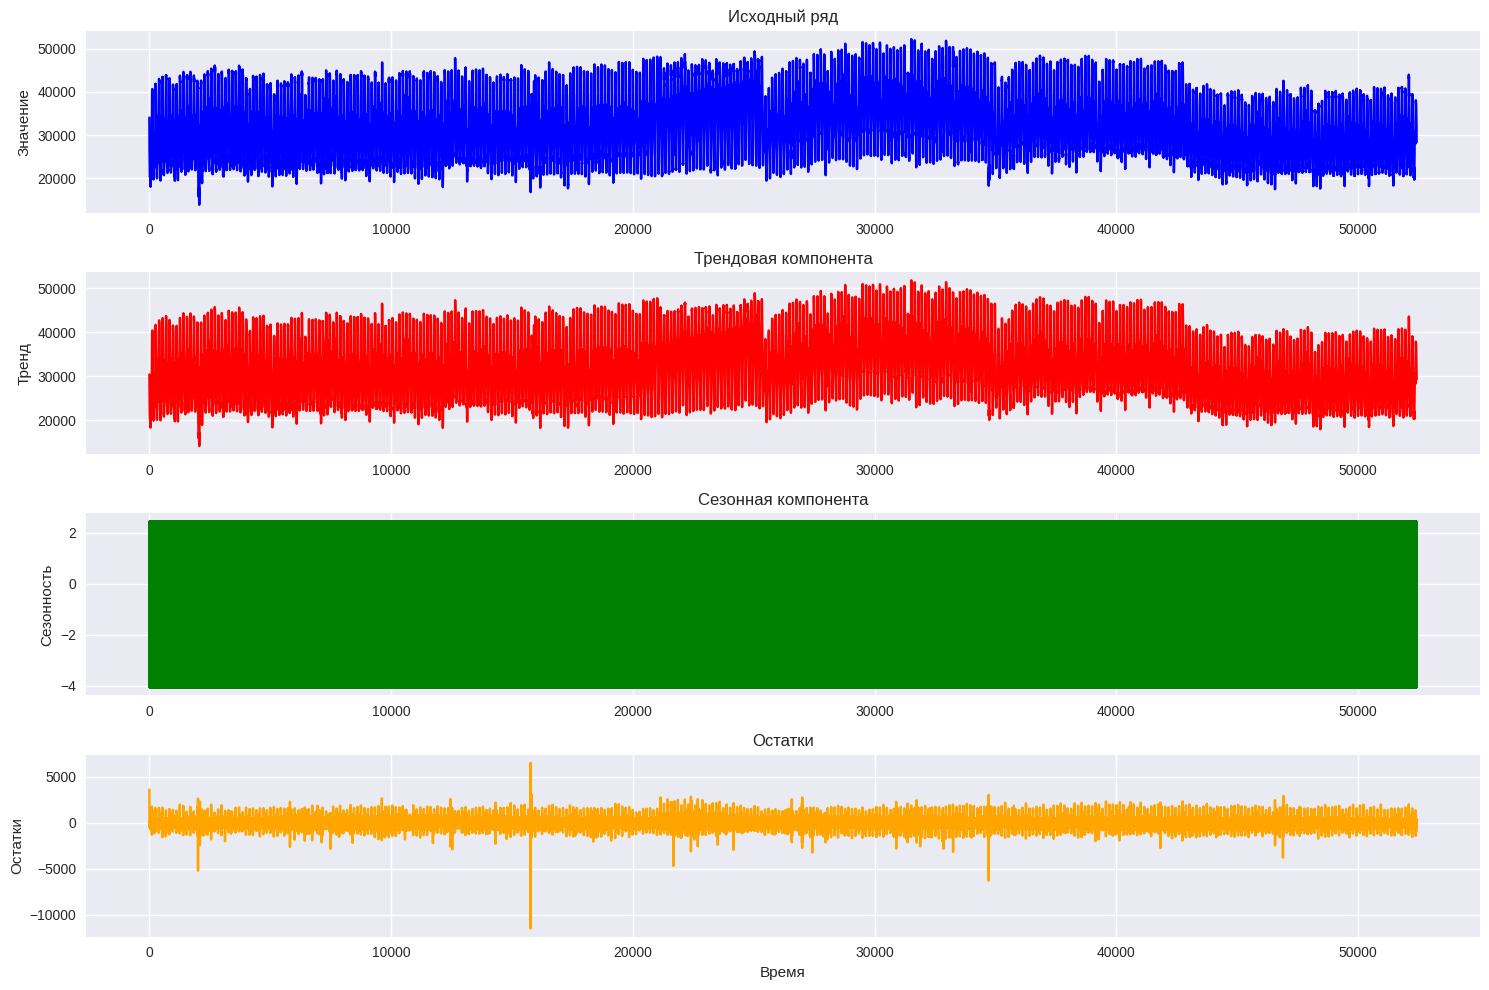

📊 АНАЛИЗ КОМПОНЕНТ ДЕКОМПОЗИЦИИ:
Модель: additive
Период сезонности: 7
Дисперсия остатков: 149970.9450
Амплитуда сезонности: 4.0527


In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

def decompose_time_series(series, model='additive', period=7):
    """
    Декомпозиция временного ряда на компоненты
    """
    decomposition = seasonal_decompose(series.dropna(),
                                     model=model,
                                     period=period,
                                     extrapolate_trend='freq')

    fig, axes = plt.subplots(4, 1, figsize=(15, 10))

    decomposition.observed.plot(ax=axes[0], title='Исходный ряд', color='blue')
    axes[0].set_ylabel('Значение')

    decomposition.trend.plot(ax=axes[1], title='Трендовая компонента', color='red')
    axes[1].set_ylabel('Тренд')

    decomposition.seasonal.plot(ax=axes[2], title='Сезонная компонента', color='green')
    axes[2].set_ylabel('Сезонность')

    decomposition.resid.plot(ax=axes[3], title='Остатки', color='orange')
    axes[3].set_ylabel('Остатки')
    axes[3].set_xlabel('Время')

    plt.tight_layout()
    plt.show()

    print("📊 АНАЛИЗ КОМПОНЕНТ ДЕКОМПОЗИЦИИ:")
    print("=" * 50)
    print(f"Модель: {model}")
    print(f"Период сезонности: {period}")
    print(f"Дисперсия остатков: {decomposition.resid.var():.4f}")
    print(f"Амплитуда сезонности: {decomposition.seasonal.abs().max():.4f}")

    return decomposition


def auto_decompose(series, period=7):
    """
    Автоматический выбор между аддитивной и мультипликативной моделью
    """
    rolling_std = series.rolling(window=period*2).std()
    trend_in_seasonality = rolling_std.diff().mean() > 0

    if trend_in_seasonality:
        print("🎯 Выбрана МУЛЬТИПЛИКАТИВНАЯ модель (растущая амплитуда сезонности)")
        model = 'multiplicative'
    else:
        print("🎯 Выбрана АДДИТИВНАЯ модель (постоянная амплитуда сезонности)")
        model = 'additive'

    return decompose_time_series(series, model=model, period=period)

decomposition = auto_decompose(df['PowerConsumption_Zone1'], period=7)